In [5]:
import numpy as np
from scipy.sparse import lil_matrix, csc_matrix, csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import eigh

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['helvetica'],'size': 16})
rc('text', usetex=True)


In [6]:
###########################################################################
# Building various sparse operators
###########################################################################

from scipy.sparse import kron

I = csr_matrix([[1,0],[0,1]])
Z = csr_matrix([[1,0],[0,-1]])
X = csr_matrix([[0,1],[1,0]])
Y = csr_matrix([[0,-1j],[1j,0]])

# TENSOR PRODUCT CONSTRUCTIONS
def tensor(pauli_list):
    op = pauli_list[0]
    for i in range(1, len(pauli_list)):
        op = kron(op, pauli_list[i], format='csr')
    return op

def build_sparse_matrix(sites, paulis, L):
    oplist = [I] * L 
    for a in range(len(sites)):
        site = sites[a]
        if paulis[a] == 'x':
            oplist[site] = X
        elif paulis[a] == 'y':
            oplist[site] = Y
        elif paulis[a] == 'z':
            oplist[site] = Z
        else:
            print("dafuq!?")
    return tensor(oplist)

def build_local_operator(i,op,L):
    return build_sparse_matrix([i], [op], L)

def build_global_operator(op, L):
    global_op = csc_matrix((2**L, 2**L), dtype='complex')
    for i in range(L):
        global_op += build_local_operator(i, op, L)
    return global_op

def build_interaction(J,op1,op2):
    L = J.shape[0]
    Hint = csc_matrix((2**L, 2**L), dtype='complex')
    for i in range(L):
        for j in range(i+1,L):
            Hint += J[i,j] * build_sparse_matrix([i,j], [op1, op2], L)
    return Hint

#### SPIN SECTOR HELPERS ####

def int2array(states, L):
    # states is (N, )
    N = states.shape[0]
    toret = np.zeros((N, L)).astype('int')
    for i in range(L):
        toret[:, -i-1] = states % 2
        states = states // 2
    return toret

def array2int(states):
    # states is (N, L)
    N = states.shape[0]
    L = states.shape[1]

    toret = np.zeros(N).astype('int')
    for i in range(L):
        toret += 2**i * states[:, -i-1]
    return toret

def get_sec_inds(L):
    sec_inds_list = []
    basis = np.arange(2**L)
    ns = np.sum(int2array(basis,L),1) #(2**L, L)
    for a in range(L+1):
        inds = np.where(ns==a)[0]
        sec_inds_list.append(inds)
    return sec_inds_list

#### STATE PREPARATION ####

def get_spin_coherent_state(thetas, phis):
    L = len(thetas)
    assert len(phis) == L
    psi = np.array([np.cos(thetas[0]/2), np.exp(-1j*phis[0])*np.sin(thetas[0]/2)])
    for j in range(1, L):
        psi0 = np.array([np.cos(thetas[j]/2), np.exp(-1j*phis[j])*np.sin(thetas[j]/2)])
        psi = np.kron(psi, psi0)
    return psi

##### EVOLVER FOR PURE ED #####

def propagate(psi0, H, ts):
    # psi0 is (d, ) initial state
    # H is (d,d) hermitian
    # ts is (N,)
    # returns (d,N) array of propagated states
    N = len(ts)

    # exactly diagonalize
    evals, V = eigh(H)
    evolver = np.exp(-1j*np.tensordot(evals,ts, axes=0)) # (d,N)
    
    #propagate the state
    psi = V.conj().T @ np.repeat(psi0[:,np.newaxis], N, axis=1)
    psi = V@(evolver*psi)
    
    return psi

def partial_trace(psi, nA, nB):
    # take the partial trace of a pure state psi
    assert len(psi) == 2**nA * 2**nB
    Psi = np.reshape(psi, 2**nA, 2**nB)
    return Psi @ Psi.conj().T

def get_haar_random_state(dimH, m):
    np.random.seed(m)
    psi0 = np.random.normal(0,1,dimH) + 1j * np.random.normal(0,1,dimH)
    return psi0/np.sqrt(np.dot(psi0.conj(), psi0))

##### BASIC LIN ALG ####

def inner(psi, phi):
    assert len(psi) == len(phi)
    return np.dot(psi.conj(), phi)

def norm(psi):
    return np.sqrt(inner(psi, psi))

def vec2op(rho_vec):
    dimH = int(np.sqrt(rho_vec.shape[0]))
    return np.reshape(rho_vec, [dimH, dimH])

def op2vec(rho_op):
    return np.ndarray.flatten(rho_op)

def compute_trace_distance(rho1_vec, rho2_vec):
    rho1 = vec2op(rho1_vec)
    rho2 = vec2op(rho2_vec)
    
    d12 = rho1-rho2
    return np.sum(np.linalg.evalsh(np.sqrt(np.d12.conj().T @ d12)))/2

def tensor_power(A0, L):
    A = A0
    for j in range(1,L):
        A = np.kron(A,A0)
    return A



## Testing time evolution

In [4]:
class SensingSimulation:

    def __init__(self, nA, nB):
        self.nA = nA
        self.nB = nB
        self.n = nA + nB
        self.build_hadamards()
        self.secular = True # assume for now

        
    #### TROTTER HELPERS

    def build_hadamards(self):
        Hx = np.array([[1,1],[1,-1]], dtype=complex)/np.sqrt(2)
        Hy = np.array([[1,-1j],[-1j,1]], dtype=complex)/np.sqrt(2)

        self.Hx_AB = tensor_power(Hx, self.n)
        self.Hy_AB = tensor_power(Hy, self.n)
        self.Hx_B = tensor_power(Hx, self.nB)
        self.Hy_B = tensor_power(Hy, self.nB)

    #### HAMILTONIAN BUILDING 

    def decode_params(self, theta):
        nA = self.nA
        nB = self.nB
        
        JAB = theta[:nA*nB]
        JAB = np.reshape(JAB, [nA, nB])
        JBB = np.zeros([nB, nB])
        #JBB = thetas[nA*nB+1:-1]
        counter = 0
        for i in range(nB):
            for j in range(i+1,nB):
                JBB[i,j]= theta[nA*nB+counter]
                counter+=1
        Delta = theta[nA*nB+counter:]
        return JAB, JBB, Delta

    def get_dipolar_molecule_hamiltonian(self, JBB, Delta):
        # returns Hamiltonian acting on the molecule! (2**nB, 2**nB) matrix
        assert JBB.shape[0] == self.nB
        assert JBB.shape[1] == self.nB
        assert Delta.shape[0] == self.nB 
        nB = self.nB
        
        # assume secular dipolar Hamiltonian
        g = np.array([1,1,-2])
        HBB = csc_matrix((2**nB, 2**nB), dtype='complex')
        for i in range(nB):
            HBB += 0.5*Delta[i]*build_local_operator(i, 'z', nB)
        for mu, p in enumerate(['x','y','z']):
            HBB += 0.5*g[mu]*build_interaction(JBB, p , p)

        return HBB

    def get_sensing_hamiltonian(self, JAB):
        nA = self.nA
        nB = self.nB
        n = self.n

        assert JAB.shape[0] == nA
        assert JAB.shape[1] == nB
        
        indsA = np.arange(nA)
        indsB = np.arange(nA, n)
        JAB_pad = np.zeros([n, n])
        JAB_pad[indsA[:,np.newaxis],indsB[np.newaxis,:]] = JAB
        JAB_pad[indsB[:,np.newaxis],indsA[np.newaxis,:]] = JAB.T

        # assume secular dipolar Hamiltonian
        g = np.array([1,1,-2])
        HAB = csc_matrix((2**n, 2**n), dtype='complex')
        for mu, p in enumerate(['x','y','z']):
            HAB += 0.5*g[mu]*build_interaction(JAB_pad, p , p)

        return HAB

    #### EXACT TIME EVOLUTION AND STATE PREP

    def get_spectrum(self, theta):
        #nA = self.nA
        nB = self.nB
        n = self.n
        self.theta = theta
        JAB, JBB, Delta = self.decode_params(theta)
        
        HAB = self.get_sensing_hamiltonian(JAB)
        HBB = self.get_dipolar_molecule_hamiltonian(JBB, Delta)
        
        if self.secular:
            # AB system
            VAB = np.zeros([2**n, 2**n], dtype='complex')
            epAB = np.zeros(2**n)
            for inds in get_sec_inds(n):
                epAB_sec, VAB_sec = eigh(HAB[inds[:,np.newaxis],inds[np.newaxis,:]].toarray())
                VAB[inds[:,np.newaxis],inds[np.newaxis,:]] = VAB_sec
                epAB[inds] = epAB_sec

            # B system
            VBB = np.zeros([2**nB, 2**nB], dtype='complex')
            epBB = np.zeros(2**nB)
            for inds in get_sec_inds(nB):
                epBB_sec, VBB_sec = eigh(HBB[inds[:,np.newaxis], inds[np.newaxis,:]].toarray())
                VBB[inds[:,np.newaxis], inds[np.newaxis,:]] = VBB_sec
                epBB[inds] = epBB_sec

        else:
            VAB, epAB = eigh(HAB.toarray())
            VBB, epBB = eigh(HBB.toarray())

        self.spec = VAB, epAB, VBB, epBB
    
    def get_thermal_ensemble(self, specB, beta, M):
        VBB, epBB = specB
        psiB_list = []
        for m in range(M):
            psi0 = get_haar_random_state(2**self.nB, m)
            evolver = np.diag(np.exp(-beta*epBB/2))
            psiB = VBB @ evolver @ (VBB.conj().T @ psi0)
            psiB = psiB / norm(psiB)
            psiB_list.append(psiB)
        return psiB_list

    def propagate_exact(self, psi0_list, tau, ts, reverse_sense=True):
        # computes the quench (H_AB, H_BB, \pm H_AB) on a list of pure states
        # returns list of evolved pure states, each element is of shape (dimH, len(ts))
        nA = self.nA
        nB = self.nB
        n = self.n
        VAB, epAB, VBB, epBB = self.spec

        evolverAB = np.exp(-1j*epAB*tau) # (dimH)
        epBB_rep = np.repeat(epBB[np.newaxis,:], 2**nA, axis=0)
        evolverBB = np.exp(-1j*np.tensordot(epBB_rep, ts, axes=0)) # (dimA, dimB, N)
        
        psi_list = []
        for psi0 in psi0_list:
            # sense
            psi = VAB @ (evolverAB * (VAB.conj().T @ psi0))

            # time evolve molecule 
            Psi = np.reshape(psi, [2**nA, 2**nB])
            Psi = Psi @ VBB.conj() # (2**nA, 2**nB)
            Psi = np.repeat(Psi[:,:,np.newaxis], len(ts), axis=2) # (nA, nB, N)
            Psi = Psi*evolverBB 
            Psi = np.swapaxes(np.tensordot(Psi, VBB, axes=((1),(1))),1,2)# (2**nA, 2**nB, N)
            psi = np.reshape(Psi, [2**n, len(ts)]) # (dimH, N)

            # reverse sense
            if reverse_sense:
                psi = VAB @ (np.conj(np.diag(evolverAB)) @ (VAB.conj().T @ psi))
            
            psi_list.append(psi)

        return psi_list
    

    #### Measure sensor operators

    def measure_local_sensor_operators(self, psi_list):
        nA = self.nA
        S_list = []
        for psi in psi_list:
            S = np.zeros([3, nA, psi.shape[1]])
            for k in range(psi.shape[1]):
                rhoA, _ = self.partial_trace(psi[:,k])
                for j in range(nA):
                    for mu, p in enumerate(['x','y','z']):
                        O = build_local_operator(j,p,nA)
                        S[mu, j, k] =  np.trace(rhoA @ O)
            S_list.append(S)
        return S_list

                
    
    #### TROTTERIZED TIME EVOLUTION    

    def set_trotter_energies(self, theta):
        # note this is only relavent for simulating Hamiltonians of the form Hx + Hy + Hz
        # will set diagonal trotter energy scales for both the sensing and molecule Hams
        # epAB is (3, 2**nA * 2**nB)
        # epBB is (3, 2**nB)
        nA = self.nA 
        nB = self.nB
        n = self.n
        g = np.array([1,1,-2])

        JAB, JBB, Delta = self.decode_params(theta)

        # pad extra zeros on coupling matrix
        indsA = np.arange(nA)
        indsB = np.arange(nA, n)
        JAB_pad = np.zeros([n, n])
        JAB_pad[indsA[:,np.newaxis],indsB[np.newaxis,:]] = JAB
        JAB_pad[indsB[:,np.newaxis],indsA[np.newaxis,:]] = JAB.T
        
        # Sensing Hamiltonian
        epAB = np.zeros([3, 2**n])
        z = 2*int2array(np.arange(2**n),n)-1 # (2**n, n)
        for mu in range(3):
            epAB[mu,:] = g[mu]*np.diag(z @ JAB_pad @ z.T) / 4

        # Molecule Hamiltonian
        epBB = np.zeros([3, 2**nB])
        z = 2*int2array(np.arange(2**nB),nB)-1 # (2**n, n)
        for mu in range(3):
            epBB[mu,:] = g[mu]*np.diag(z @ JBB @ z.T) / 4
            if mu ==2:
                epBB[mu,:] += z @ Delta / 2

        self.epAB = epAB
        self.epBB = epBB


    def apply_sensing_trotter_step(self, psi, dt):
        Hx = self.Hx_AB
        Hy = self.Hy_AB
        epAB = self.epAB
        DAB = np.exp(-1j * epAB * dt / 2) 

        # ZZ
        psi = DAB[2,:] * psi
        # XX
        psi = Hx.conj().T @ (DAB[0,:] * (Hx @ psi))
        # YY
        psi = Hy.conj().T @ (DAB[1,:]**2 * (Hy @ psi))
        # XX
        psi = Hx.conj().T @ (DAB[0,:] * (Hx @ psi))
        # ZZ
        psi = DAB[2,:] * psi
    
        return psi

    def apply_molecule_trotter_step(self, psi, dt):
        nA = self.nA
        nB = self.nB
        Hx = self.Hx_B
        Hy = self.Hy_B

        epBB = self.epBB

        DB = np.exp(-1j*epBB*dt/2)
        DB = np.repeat(DB[:,np.newaxis,:], 2**nA, axis=1)

        Psi = np.reshape(psi, [2**nA, 2**nB])
        # ZZ
        Psi = DB[2,:,:] * Psi
        # XX
        Psi =  ((Psi @ Hx.T) * DB[0,:,:]) @ Hx.conj()
        # YY
        Psi =  ((Psi @ Hy.T) * (DB[1,:,:]**2)) @ Hy.conj()
        # XX
        Psi =  ((Psi @ Hx.T) * DB[0,:,:]) @ Hx.conj()
        # ZZ
        Psi = DB[2,:,:] * Psi
        psi = np.ndarray.flatten(Psi)

        return psi # (2**nA, 2**nB) 

    def get_thermal_ensemble_trotter(self, dtau, beta, M):
        #VBB, epBB = specB
        psiB_list = []
        norm_list = []

        N_tau = int(beta/dtau)
        epBB = self.epBB
        #_, epBB = self.get_trotter_energies(theta)
        # right multipy the state
        #Psi = np.reshape(psi, [nA, nB])
        Hx = self.Hx_B
        Hy = self.Hy_B
        DB = np.exp(-epBB*dtau/2)
        for m in range(M):
            psi = get_haar_random_state(2**self.nB, m)
            for k in range(N_tau):
                # ZZ
                psi = DB[2,:] * psi
                # XX
                psi = Hx @ psi
                psi = Hx.conj().T @ (DB[0,:] * psi)
                # YY
                psi = Hy @ psi
                psi = Hy.conj().T @ (DB[1,:]**2 * psi)
                # XX
                psi = Hx @ psi
                psi = Hx.conj().T @ (DB[0,:] * psi)
                # ZZ
                psi = DB[2,:] * psi

            psiB_list.append(psi)
            norm_list.append(np.dot(psi.conj(), psi))
                    
        return psiB_list, norm_list


    def propagate_trotter(self, psi0_list, tau, dtau, t, dt, n_measure, reverse_sense=True):
        n = self.n
        ts = np.arange(0, t, n_measure*dt)
        N_t = len(ts)
        #N_t = int(n_evolve/n_measure)
        #print(N_t)
        #N_t = int(np.max(ts)/dt)
        N_tau = int(tau/dtau)
        #theta = self.theta

        psi_list = []
        
        for psi0 in psi0_list:
            psi = np.zeros([2**n, N_t], dtype='complex128')
            psi1 = psi0.copy()
            
            # sense
            for k in range(N_tau):
                psi1 = self.apply_sensing_trotter_step(psi1, dtau)

            # evolve
            psi2 = psi1.copy()
            counter = 0
            for l in range(int(t/dt)):
                print(l)
                psi2 = self.apply_molecule_trotter_step(psi2, dt)

                # reverse sense, then save the state
                if reverse_sense:
                    psi3 = psi2.copy()
                    print('time reversing...')
                    for k in range(N_tau):
                        psi3 = self.apply_sensing_trotter_step(psi3, -dtau)
                    if int(np.mod(l,n_measure))==0: 
                        print('measuring!')
                        psi[:, counter] = psi3
                        counter += 1
                        print()

                else:
                    if int(np.mod(l,n_measure))==0: 
                        psi[:,counter] = psi2
                        counter += 1
                
            psi_list.append(psi)

        return psi_list
            

    def propagate_general_trotter(self, psi0_list, tau_list, dtau, t_list, dt, theta):
        # UNTESTED
        assert len(tau_list) == len(t_list)
        psi_list = psi0_list
        for tau, t in zip(tau_list, t_list):
            psi_list = self.propagate_trotter(psi_list, tau, dtau, t, dt, theta, time_reverse=False)
        return psi_list


    def partial_trace(self, psi):
        nA = self.nA
        nB = self.nB
        Psi = np.reshape(psi, [2**nA, 2**nB])

        rhoA = Psi @ Psi.conj().T
        rhoB =  Psi.conj().T @ Psi

        return rhoA, rhoB
        #rhoA_vec = op2vec(Psi @ Psi.conj().T)
        #rhoB_vec = op2vec(Psi @ Psi.conj().T)

        #return rhoA_vec, rhoB_vec


Warm up with autodiff. 

Consider a single qubit pure state. 
$$
|\psi \rangle  = e^{-i H(\theta) t} |+ \rangle
$$

where $H(\theta) = \Omega(\theta) X + \Delta(\theta) Z$. Lets calculate the Fischer information of this state with respect to $\theta$.

In general we will consider a time-independent Hamiltonian
$$
H(t, \theta) = \sum_{\alpha} f_\alpha(t)  \underbrace{\sum_\mu \theta^{\alpha}_{\mu} \hat{h}^{\alpha}_\mu}_{H^{\alpha}(\theta^\alpha)} 
$$
where $f_\alpha(t)=\pm 1, 0$ is essentially modelling the decoupling sequences modulating each Hamiltonian, $H_\alpha$. $\alpha$ indexes in the simplest case either $AB$ or $BB$ for sensor to molecule coupling and molecular coupling.  

For example: 

$$
H_{AB} = \sum_{aj} J^{AB}_{ij} \left(X_a X_j +Y_a Y_j -2 Z_a Z_j \right)
H_{BB} = \sum_{ij} J^{BB}_{ij} \left(X_i X_j +Y_i Y_j -2 Z_i Z_j \right)
$$

### Testing Exact Time evolution

In [2]:
def encode_params(JAB, JBB, Delta):
    nA = JAB.shape[0]
    nB = JAB.shape[1]
    assert JBB.shape[0]==nB
    assert JBB.shape[1]==nB
    assert len(Delta) == nB

    dim = int(nA*nB+nB*(nB+1)/2)
    theta = np.zeros([dim])
    JAB = np.reshape(JAB, [nA, nB])
    theta[:nA*nB] = JAB
    counter = 0
    for i in range(nB):
        for j in range(i+1,nB):
            theta[nA*nB+counter] = JBB[i,j]
            counter += 1
    theta[nA*nB+counter:] = Delta
    return theta

In [10]:
# start with a simple 3 spin system
nA = 1
nB = 2
g = 1.1
J = 2.3
h1 = 0.2
h2 = 0.4

JAB = g*np.array([[1,1]])
JB = J*np.array([[0,1],[1,0]])
Delta = np.array([h1,h2])

sim = SensingSimulation(nA, nB)
theta = encode_params(JAB, JB, Delta)
sim.get_spectrum(theta)

# infinite temperature bath, exact dynamics
M = 10
psi0_A =np.ones(2)/np.sqrt(2)
psi0_list = [np.kron(psi0_A, get_haar_random_state(2**nB, m)) for m in range(M)]

tau = 2
ts = np.linspace(0, 10, 500)

# exact sim
psi_list_1 = sim.propagate_exact(psi0_list, tau, ts)
psi_list_2 = sim.propagate_exact(psi0_list, tau, ts, reverse_sense=False)
S_list_1 = sim.measure_local_sensor_operators(psi_list_1)
S_list_2 = sim.measure_local_sensor_operators(psi_list_2)

    


# trotter sim
#dtau = 1e-2
#dt = 1e-2
#psi_list_trotter = sim.propagate_trotter(psi0_list, tau, dtau, np.max(ts), dt)




/var/folders/s3/3_6505pn269_dtgjnx_5zxxr0000gn/T/ipykernel_4968/1016665764.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  S[mu, j, k] =  np.trace(rhoA @ O)


In [7]:
def plot_observables(ts, S_list):
    M = len(S_list)
    nA = S_list[0].shape[1]
    Savg = np.zeros([3,nA,len(ts)])
    for m, S in enumerate(S_list):
        Savg += S/M
    plt.plot(ts, np.mean(Savg[0,:,:],0))
    return np.mean(Savg[0,:,:],0)

def get_global_observables(S_list):
    M = len(S_list)
    nA = S_list[0].shape[1]
    Savg = np.zeros([3,nA,len(ts)])
    for m, S in enumerate(S_list):
        Savg += S/M
    #plt.plot(ts, np.mean(Savg[0,:,:],0))
    return np.mean(Savg,1)

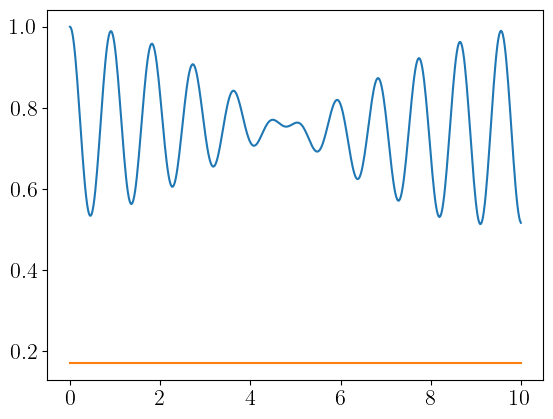

In [8]:
Savg1 = plot_observables(ts, S_list_1)
Savg2 = plot_observables(ts, S_list_2)

In [ ]:
# make a 2d color plot of the signal
ts = np.linspace(0,10,500)
taus = np.linspace(0,10,500)

signal_A = np.zeros([len(ts), len(taus)])
signal_B = np.zeros([len(ts), len(taus)])

for l, tau in enumerate(taus):
    print(l)
    S_list_A = sim.measure_local_sensor_operators(sim.propagate_exact(psi0_list, tau, ts))
    signal_A[:, l] = get_global_observables(S_list_A)[0,:]
    S_list_B = sim.measure_local_sensor_operators(sim.propagate_exact(psi0_list, 2*tau, ts, reverse_sense=False))
    signal_B[:, l] = get_global_observables(S_list_B)[0,:]
   

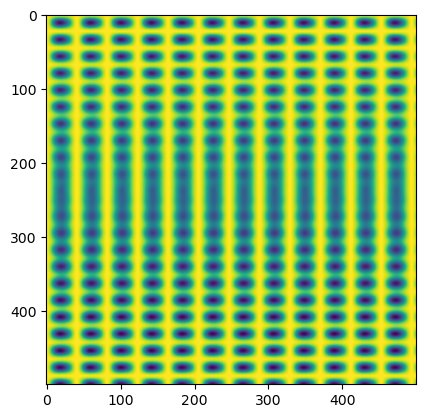

In [101]:
plt.imshow(signal_A)

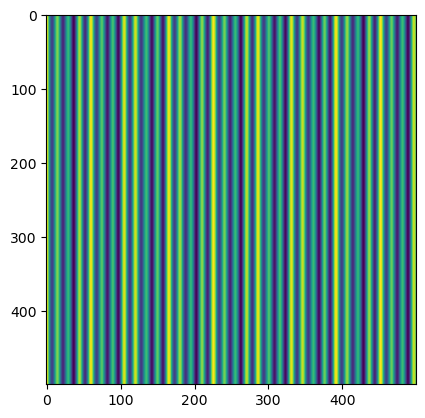

In [99]:
plt.imshow(signal_B)

### Testing trotter evolution

In [14]:
# start with a simple 3 spin system
nA = 1
nB = 2
g = 1.1
J = 2.3
h1 = 0.2
h2 = 0.4

JAB = g*np.array([[1,1]])
JB = J*np.array([[0,1],[1,0]])
Delta = np.array([h1,h2])

sim = SensingSimulation(nA, nB)
theta = encode_params(JAB, JB, Delta)
sim.get_spectrum(theta)

# infinite temperature bath, exact dynamics
M = 2
psi0_A =np.ones(2)/np.sqrt(2)
psi0_list = [np.kron(psi0_A, get_haar_random_state(2**nB, m)) for m in range(M)]


# time evolution params
tau = 2
dtau = 1e-2
t = 10
n_measure = 2
dt = 1e-2
ts = np.arange(0,t,n_measure*dt)

# exact sim
psi_list_1 = sim.propagate_exact(psi0_list, tau, ts)
S_list_1 = sim.measure_local_sensor_operators(psi_list_1)
Savg1 = get_global_observables(S_list_1)[0,:]


/var/folders/s3/3_6505pn269_dtgjnx_5zxxr0000gn/T/ipykernel_4968/1016665764.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  S[mu, j, k] =  np.trace(rhoA @ O)


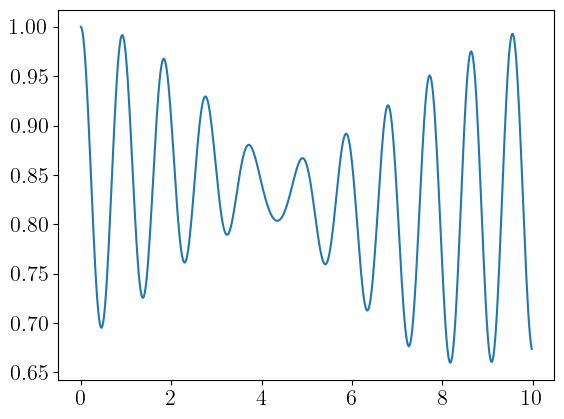

In [65]:
plt.plot(ts, Savg1)

In [66]:

sim.set_trotter_energies(theta)
psi_list_2 = sim.propagate_trotter(psi0_list, tau, dtau, t, dt, n_measure)
S_list_2 = sim.measure_local_sensor_operators(psi_list_2)

Savg2 = get_global_observables(S_list_2)[0,:]


0
time reversing...
measuring!

1
time reversing...
2
time reversing...
measuring!

3
time reversing...
4
time reversing...
measuring!

5
time reversing...
6
time reversing...
measuring!

7
time reversing...
8
time reversing...
measuring!

9
time reversing...
10
time reversing...
measuring!

11
time reversing...
12
time reversing...
measuring!

13
time reversing...
14
time reversing...
measuring!

15
time reversing...
16
time reversing...
measuring!

17
time reversing...
18
time reversing...
measuring!

19
time reversing...
20
time reversing...
measuring!

21
time reversing...
22
time reversing...
measuring!

23
time reversing...
24
time reversing...
measuring!

25
time reversing...
26
time reversing...
measuring!

27
time reversing...
28
time reversing...
measuring!

29
time reversing...
30
time reversing...
measuring!

31
time reversing...
32
time reversing...
measuring!

33
time reversing...
34
time reversing...
measuring!

35
time reversing...
36
time reversing...
measuring!

37
ti

/var/folders/nb/5gbs4wt96rs93v4n58zhrnjh0000gn/T/ipykernel_1601/1998481057.py:178: ComplexWarning: Casting complex values to real discards the imaginary part
  S[mu, j, k] =  np.trace(rhoA @ O)


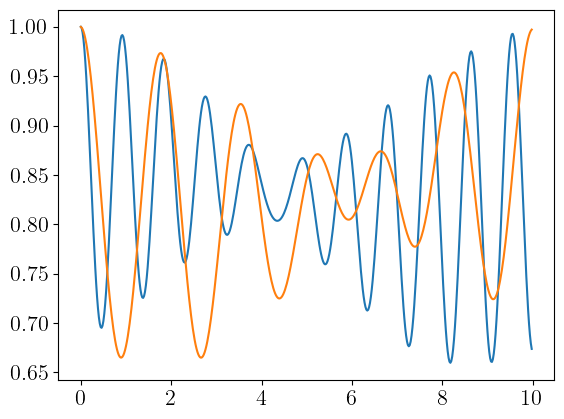

In [67]:
plt.plot(ts, Savg1)
plt.plot(ts, Savg2)

## Autodiffing the sensor states

In [8]:
import jax
from jax import jit

import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd#, jacrev
from jax.scipy.linalg import expm

from jax.lax import fori_loop

jax.config.update("jax_enable_x64", True)


# Helper Functions

def int2array(states, L):
    # states is (N, )
    N = states.shape[0]
    toret = jnp.zeros((N, L)).astype('int')
    for i in range(L):
        toret = toret.at[:,-1-1].set(states % 2)
        #toret[:, -i-1] = states % 2
        states = states // 2
    return toret

def array2int(states):
    # states is (N, L)
    N = states.shape[0]
    L = states.shape[1]

    toret = jnp.zeros(N).astype('int')
    for i in range(L):
        toret += 2**i * states[:, -i-1]
    return toret

def get_sec_inds(L):
    sec_inds_list = []
    basis = jnp.arange(2**L)
    ns = jnp.sum(int2array(basis,L),1) #(2**L, L)
    for a in range(L+1):
        inds = jnp.where(ns==a)[0]
        sec_inds_list.append(inds)
    return sec_inds_list



def get_haar_random_state(dimH, m):
    np.random.seed(m)
    psi0 = np.random.normal(0,1,dimH) + 1j * np.random.normal(0,1,dimH)
    return psi0/np.sqrt(np.dot(psi0.conj(), psi0))


## Jaxed helper functions

def build_hadamards(n):

    def tensor_power(A0, L):
        A = A0
        for j in range(1,L):
            A = jnp.kron(A, A0)
        return A

    Hx = jnp.array([[1,1],[1,-1]], dtype=complex)/jnp.sqrt(2)
    Hy = jnp.array([[1,-1j],[-1j,1]], dtype=complex)/jnp.sqrt(2)

    return tensor_power(Hx,n), tensor_power(Hy,n)

def decode_params(theta, nA, nB):
    JAB = theta[:nA*nB]
    JAB = jnp.reshape(JAB, [nA, nB])
    JBB = jnp.zeros([nB, nB])
    counter = 0
    for i in range(nB):
        for j in range(i+1,nB):
            JBB = JBB.at[i,j].set(theta[nA*nB+counter])
            counter+=1
    Delta = theta[nA*nB+counter:]
    return JAB, JBB, Delta

    
def get_trotter_energies(JAB, JBB, Delta):
    g = jnp.array([1,1,-2])
    n = JAB.shape[0] + JBB.shape[0]
    indsA = jnp.arange(nA)
    indsB = jnp.arange(nA, n)
    JAB_pad = jnp.zeros([n, n])
    #JAB_pad[indsA[:,jnp.newaxis],indsB[jnp.newaxis,:]] = JAB
    JAB_pad = JAB_pad.at[indsA[:,jnp.newaxis],indsB[jnp.newaxis,:]].set(JAB)
    #JAB_pad[indsB[:,jnp.newaxis],indsA[jnp.newaxis,:]] = JAB.T
    JAB_pad = JAB_pad.at[indsB[:,jnp.newaxis],indsA[jnp.newaxis,:]].set(JAB.T)

    
    # Sensing Hamiltonian
    epAB = jnp.zeros([3, 2**n])
    z = 2*int2array(jnp.arange(2**n),n)-1 # (2**n, n)
    for mu in range(3):
        epAB = epAB.at[mu,:].set(g[mu]*jnp.diag(z @ JAB_pad @ z.T) / 4)
        #epAB[mu,:] = g[mu]*jnp.diag(z @ JAB_pad @ z.T) / 4

    # Molecule Hamiltonian
    epBB = jnp.zeros([3, 2**nB])
    z = 2*int2array(jnp.arange(2**nB),nB)-1 # (2**n, n)
    for mu in range(3):
        #epBB[mu,:] = g[mu]*jnp.diag(z @ JBB @ z.T) / 4
        epBB = epBB.at[mu,:].set(g[mu]*jnp.diag(z @ JBB @ z.T) / 4)
        if mu ==2:
            #epBB[mu,:] += z @ Delta / 2
            epBB = epBB.at[mu,:].set(z @ Delta / 2)

    return epAB, epBB


def apply_sensing_trotter_step(epAB, psi, dt):
    n = int(jnp.round(jnp.log2(epAB.shape[1])))
    assert jnp.isclose(2**n, epAB.shape[1])
    Hx, Hy = build_hadamards(n)
    DAB = jnp.exp(-1j * epAB * dt / 2) 

    # ZZ
    psi = DAB[2,:] * psi
    # XX
    psi = Hx @ psi
    psi = Hx.conj().T @ (DAB[0,:] * psi)
    # YY
    psi = Hy @ psi
    psi = Hy.conj().T @ (DAB[1,:]**2 * psi)
    # XX
    psi = Hx @ psi
    psi = Hx.conj().T @ (DAB[0,:] * psi)
    # ZZ
    psi = DAB[2,:] * psi

    return psi


def apply_molecule_trotter_step(epBB, psi, dt):
    n = int(jnp.round(jnp.log2(len(psi))))
    nB = int(jnp.round(jnp.log2(epBB.shape[1])))
    assert jnp.isclose(2**n, len(psi))
    assert jnp.isclose(2**nB, epBB.shape[1])
    nA = int(n-nB)
    #nA = n-nB
    Hx, Hy = build_hadamards(nB)
    #nB = self.nB
    # right multipy the state
    DB = jnp.exp(-1j*epBB*dt/2)
    DB = jnp.repeat(DB[:,jnp.newaxis,:], 2**nA, axis=1)

    Psi = jnp.reshape(psi, [2**nA, 2**nB])
    # ZZ
    Psi = DB[2,:,:] * Psi
    # XX
    Psi =  ((Psi @ Hx.T) * DB[0,:,:]) @ Hx.conj()
    # YY
    Psi =  ((Psi @ Hy.T) * (DB[1,:,:]**2)) @ Hy.conj()
    # XX
    Psi =  ((Psi @ Hx.T) * DB[0,:,:]) @ Hx.conj()
    # ZZ
    Psi = DB[2,:,:] * Psi
    psi = jnp.ndarray.flatten(Psi)

    return psi # (2**nA, 2**nB) 
    # apply the resulting evolution.
    #Rx = hx_U @ jnp.diag(jnp.exp(-1j * tau * hx_l)) @ hx_U.conj().T
    #Udet = ntot_U @ jnp.diag(jnp.exp(-1j * det * ntot_l)) @ ntot_U.conj().T

    #return jnp.dot(Udet, jnp.dot(Rx, psi))
    
def partial_trace(psi, nA, nB):
    #nA = self.nA
    #nB = self.nB
    Psi = jnp.reshape(psi, [2**nA, 2**nB])

    rhoA = Psi @ Psi.conj().T
    rhoB =  Psi.conj().T @ Psi

    return rhoA, rhoB

In [76]:
jnp.round(0.1)

Array(0., dtype=float64, weak_type=True)

In [88]:

def apply_sensing_trotter_step(epAB, psi, dt):
    #print(epAB.shape)
    n = int(jnp.round(jnp.log2(epAB.shape[1])))
    
    assert jnp.isclose(2**n, epAB.shape[1])

    #print(jnp.log2(epAB.shape[1]))
    #print(n)
    # Hx, Hy = build_hadamards(n)
    # DAB = jnp.exp(-1j * epAB * dt / 2) 
    #print(DAB.shape)
    #print((DAB[2,:] * psi).shape)
    #print(Hx.shape)
    # ZZ
    # psi = DAB[2,:] * psi
    # # XX
    # psi = Hx @ psi
    # psi = Hx.conj().T @ (DAB[0,:] * psi)
    # # YY
    # psi = Hy @ psi
    # psi = Hy.conj().T @ (DAB[1,:]**2 * psi)
    # # XX
    # psi = Hx @ psi
    # psi = Hx.conj().T @ (DAB[0,:] * psi)
    # # ZZ
    # psi = DAB[2,:] * psi

    return psi

epAB, _ = get_trotter_energies(JAB, JB, Delta)
psi = get_haar_random_state(8, 0)
apply_sensing_trotter_step(epAB, psi, dt=0.01)



array([ 0.41768427-0.02443969j,  0.0947474 +0.09721964j,
        0.23174112+0.03410598j,  0.53058848+0.34433625j,
        0.44219187+0.18019504j, -0.2313954 +0.02880966j,
        0.2249576 +0.10509591j, -0.03583767+0.07900589j])

In [15]:
nA = 1
nB = 2
g = 1.1
J = 2.3
h1 = 0.2
h2 = 0.4

JAB = g*np.array([[1,1]])
JB = J*np.array([[0,1],[1,0]])
Delta = np.array([h1,h2])
theta = encode_params(JAB, JB, Delta)


# time evolution params
tau = 2
dtau = 1e-2
t = 10
n_measure = 50
dt = 1e-2
ts = np.arange(0,t,n_measure*dt)


M = 2
psi0_A =np.ones(2)/np.sqrt(2)
psi0_list = [np.kron(psi0_A, get_haar_random_state(2**nB, m)) for m in range(M)]


### Looping through initial states

In [100]:
def build_evolution(hyperparams):
    nA = hyperparams['nA']
    nB = hyperparams['nB']
    n = nA + nB

    t = hyperparams['t']
    n_measure = hyperparams['n_measure']
    dt = hyperparams['dt']
    tau = hyperparams['tau']
    dtau = hyperparams['dtau']

    ts = np.arange(0, t, n_measure*dt)
    N_t = len(ts)

    N_tau = int(tau/dtau)

    reverse_sense = hyperparams['reverse_sense']
    psi0_list = hyperparams["psi0_list"] 

    Hx, Hy = build_hadamards(n)
    Hx_nB, Hy_nB = build_hadamards(nB)
    
    # any variational (input) parameters should be included in params.
    def apply_evolution(theta, args):

        # this is where the Ham params go!
        JAB, JBB, Delta = decode_params(theta, nA, nB)
        epAB, epBB = get_trotter_energies(JAB, JBB, Delta)

        DAB = jnp.exp(-1j * epAB * dt / 2) 
        DB = jnp.exp(-1j*epBB*dt/2)
        DB = jnp.repeat(DB[:,jnp.newaxis,:], 2**nA, axis=1)

        def apply_sensing_trotter_step(t0, psi):
            psi = DAB[2,:] * psi # ZZ
            psi = Hx @ psi # XX
            psi = Hx.conj().T @ (DAB[0,:] * psi)
            psi = Hy @ psi # YY
            psi = Hy.conj().T @ (DAB[1,:]**2 * psi)
            psi = Hx @ psi # XX
            psi = Hx.conj().T @ (DAB[0,:] * psi)
            psi = DAB[2,:] * psi # ZZ
            return psi
        
        def apply_reverse_sensing_trotter_step(t0, psi):
            psi = DAB[2,:].conj() * psi # ZZ
            psi = Hx @ psi # XX
            psi = Hx.conj().T @ (DAB[0,:].conj() * psi)
            psi = Hy @ psi # YY
            psi = Hy.conj().T @ (DAB[1,:].conj()**2 * psi)
            psi = Hx @ psi # XX
            psi = Hx.conj().T @ (DAB[0,:].conj() * psi)
            psi = DAB[2,:].conj() * psi # ZZ
            return psi

        def apply_molecule_trotter_step(t0, psi):
            nA = int(n-nB)
            Psi = jnp.reshape(psi, [2**nA, 2**nB])
            Psi = DB[2,:,:] * Psi # ZZ
            Psi =  ((Psi @ Hx_nB.T) * DB[0,:,:]) @ Hx_nB.conj() # XX
            Psi =  ((Psi @ Hy_nB.T) * (DB[1,:,:]**2)) @ Hy_nB.conj() # YY
            Psi =  ((Psi @ Hx_nB.T) * DB[0,:,:]) @ Hx_nB.conj() # XX
            Psi = DB[2,:,:] * Psi # ZZ
            psi = jnp.ravel(Psi)
            return psi 
        
        psi_list = []
        
        for psi0 in psi0_list:
            #psi_intermediates = []
            psi1 = psi0.copy()
            
            # sense
            psi1 = fori_loop(0, N_tau, apply_sensing_trotter_step, psi1)

            # evolve
            psi_cont = jnp.zeros((N_t+1, 2**n), dtype='complex128')
            psi_cont = psi_cont.at[0,:].set(psi1)

            def evolve_molecule(t0, psi_cont):
                psi2 = psi_cont[t0,:]
                psi3 = fori_loop(0, N_tau, apply_reverse_sensing_trotter_step, psi2)
                psi2 = fori_loop(0, n_measure, apply_molecule_trotter_step, psi2)
                
                
                psi_cont = psi_cont.at[t0,:].set(psi3)
                psi_cont = psi_cont.at[t0+1,:].set(psi2)
                return psi_cont
            
            def evolve_molecule_noreverse(t0, psi_cont):
                psi2 = psi_cont[t0,:]
                psi2 = fori_loop(0, n_measure, apply_molecule_trotter_step, psi2)
                psi_cont = psi_cont.at[t0+1,:].set(psi2)
                return psi_cont
            if reverse_sense:
                psi_cont = fori_loop(0, N_t, evolve_molecule, psi_cont)
            else:
                psi_cont = fori_loop(0, N_t, evolve_molecule_noreverse, psi_cont)
            psi_list.append(psi_cont[:-1,:])

        return jnp.array(psi_list)
    
    return jit(apply_evolution)

In [101]:
hyperparams = {}
args = {}
hyperparams['nA'] = nA 
hyperparams['nB'] = nB 
hyperparams['t'] = t 
hyperparams['n_measure'] = n_measure 
hyperparams['dt'] = dt 
hyperparams['tau'] = tau 
hyperparams['dtau'] = dtau

ts = np.arange(0, t, n_measure*dt)
N_t = len(ts)
N_tau = int(tau/dtau)

hyperparams['reverse_sense'] = False
hyperparams["psi0_list"] = psi0_list

sensing_evol = build_evolution(hyperparams)

psi_grad = jacfwd(sensing_evol)
psi_grad(theta, args)
# sensing_evol(theta, args)

Array([[[[-3.48310790e-15+1.37240479e-14j,
          -2.60208521e-18+1.08420217e-18j,
           0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j],
         [ 1.88965597e-15-3.09669825e-15j,
           6.72205347e-18-1.95156391e-18j,
           0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j],
         [-1.57393629e-15+5.80557737e-15j,
           2.49366500e-18+1.08420217e-19j,
           0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j],
         ...,
         [-1.29226057e-15-6.35407525e-15j,
           2.05998413e-18+1.39862080e-17j,
           0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j,
           0.00000000e+00+0.00000000e+00j],
         [ 4.55831119e-15+1.63313373e-15j,
           1.68051337e-17+2.81892565e-18j,
           0.00000000e+00+0.00000000

In [90]:
sensing_evol(theta, args)

Array([[[ 0.25630711+0.25983313j, -0.01979019-0.27353513j,
          0.34473946+0.19309882j,  0.35887111-0.08160499j,
          0.25630711+0.25983313j, -0.01979019-0.27353513j,
          0.34473946+0.19309882j,  0.35887111-0.08160499j],
        [ 0.16915236+0.11793152j, -0.09445936-0.34049837j,
          0.45142181+0.20745368j,  0.25830063-0.13813049j,
          0.16915236+0.11793152j, -0.09445936-0.34049837j,
          0.45142181+0.20745368j,  0.25830063-0.13813049j],
        [ 0.08758754-0.05932731j, -0.14500828-0.36681671j,
          0.48650677+0.20361457j,  0.12885905-0.19614895j,
          0.08758754-0.05932731j, -0.14500828-0.36681671j,
          0.48650677+0.20361457j,  0.12885905-0.19614895j],
        [ 0.02839295-0.2414383j , -0.17258079-0.34365201j,
          0.44954854+0.16776928j, -0.00945631-0.25038112j,
          0.02839295-0.2414383j , -0.17258079-0.34365201j,
          0.44954854+0.16776928j, -0.00945631-0.25038112j],
        [-0.00158227-0.39476729j, -0.18284033-0.2705

In [80]:
psi_grad(theta, args).shape

(2, 20, 8, 5)

### Tensorial initial states

Lets assume that the inputted state is a matrix, $\psi_{}$

In [ ]:
def build_evolution(hyperparams):
    nA = hyperparams['nA']
    nB = hyperparams['nB']
    n = nA + nB

    t = hyperparams['t']
    n_measure = hyperparams['n_measure']
    dt = hyperparams['dt']
    tau = hyperparams['tau']
    dtau = hyperparams['dtau']

    ts = np.arange(0, t, n_measure*dt)
    N_t = len(ts)

    N_tau = int(tau/dtau)

    reverse_sense = hyperparams['reverse_sense']
    psi0_list = hyperparams["psi0_list"] 

    Hx, Hy = build_hadamards(n)
    Hx_nB, Hy_nB = build_hadamards(nB)
    
    # any variational (input) parameters should be included in params.
    def apply_evolution(theta, args):

        # this is where the Ham params go!
        JAB, JBB, Delta = decode_params(theta, nA, nB)
        epAB, epBB = get_trotter_energies(JAB, JBB, Delta)

        DAB = jnp.exp(-1j * epAB * dt / 2) 
        DB = jnp.exp(-1j*epBB*dt/2)
        DB = jnp.repeat(DB[:,jnp.newaxis,:], 2**nA, axis=1)

        def apply_sensing_trotter_step(t0, psi):
            psi = DAB[2,:] * psi # ZZ
            psi = Hx @ psi # XX
            psi = Hx.conj().T @ (DAB[0,:] * psi)
            psi = Hy @ psi # YY
            psi = Hy.conj().T @ (DAB[1,:]**2 * psi)
            psi = Hx @ psi # XX
            psi = Hx.conj().T @ (DAB[0,:] * psi)
            psi = DAB[2,:] * psi # ZZ
            return psi
        
        def apply_reverse_sensing_trotter_step(t0, psi):
            psi = DAB[2,:].conj() * psi # ZZ
            psi = Hx @ psi # XX
            psi = Hx.conj().T @ (DAB[0,:].conj() * psi)
            psi = Hy @ psi # YY
            psi = Hy.conj().T @ (DAB[1,:].conj()**2 * psi)
            psi = Hx @ psi # XX
            psi = Hx.conj().T @ (DAB[0,:].conj() * psi)
            psi = DAB[2,:].conj() * psi # ZZ
            return psi

        def apply_molecule_trotter_step(t0, psi):
            nA = int(n-nB)
            Psi = jnp.reshape(psi, [2**nA, 2**nB])
            Psi = DB[2,:,:] * Psi # ZZ
            Psi =  ((Psi @ Hx_nB.T) * DB[0,:,:]) @ Hx_nB.conj() # XX
            Psi =  ((Psi @ Hy_nB.T) * (DB[1,:,:]**2)) @ Hy_nB.conj() # YY
            Psi =  ((Psi @ Hx_nB.T) * DB[0,:,:]) @ Hx_nB.conj() # XX
            Psi = DB[2,:,:] * Psi # ZZ
            psi = jnp.ravel(Psi)
            return psi 
        
        psi_list = []
        
        for psi0 in psi0_list:
            #psi_intermediates = []
            psi1 = psi0.copy()
            
            # sense
            psi1 = fori_loop(0, N_tau, apply_sensing_trotter_step, psi1)

            # evolve
            psi_cont = jnp.zeros((N_t+1, 2**n), dtype='complex128')
            psi_cont = psi_cont.at[0,:].set(psi1)

            def evolve_molecule(t0, psi_cont):
                psi2 = psi_cont[t0,:]
                psi3 = fori_loop(0, N_tau, apply_reverse_sensing_trotter_step, psi2)
                psi2 = fori_loop(0, n_measure, apply_molecule_trotter_step, psi2)
                
                
                psi_cont = psi_cont.at[t0,:].set(psi3)
                psi_cont = psi_cont.at[t0+1,:].set(psi2)
                return psi_cont
            
            def evolve_molecule_noreverse(t0, psi_cont):
                psi2 = psi_cont[t0,:]
                psi2 = fori_loop(0, n_measure, apply_molecule_trotter_step, psi2)
                psi_cont = psi_cont.at[t0+1,:].set(psi2)
                return psi_cont
                
            if reverse_sense:
                psi_cont = fori_loop(0, N_t, evolve_molecule, psi_cont)
            else:
                psi_cont = fori_loop(0, N_t, evolve_molecule_noreverse, psi_cont)
            psi_list.append(psi_cont[:-1,:])

        return jnp.array(psi_list)
    
    return jit(apply_evolution)

In [69]:
sensing_evol_jit = jit(sensing_evol)

In [51]:
import timeit

In [74]:
sensing_evol_jit(theta, args)

print("hello")

hello


In [63]:
%timeit sensing_evol(theta, args)

162 ms ± 773 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
%timeit sensing_evol_jit(theta, args)

4.12 ms ± 44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [81]:
psi_grad

<function jax._src.api.jacfwd.<locals>.jacfun(*args, **kwargs)>

## Computing the QFIM

In [ ]:
def get_QFIM(rho, drho_list):
    # returns both the list of SLDs and QFIM
    dimH = rho.shape[0]
    # work in vectorized formalism
    rho1 = np.kron(rho, np.eye(dimH))
    rho2 = np.kron(np.eye(dimH), rho.conj())
    S = np.linalg.pinv(rho1+rho2)
    #
    F = np.zeros([len(drho_list), len(drho_list)])
    l_list = []
    for a, drho_a in enumerate(drho_list):
        drho_a_vec = op2vec(drho_a)
        la = S @ drho_a_vec
        l_list.append(la)
        for b, drho_b in enumerate(drho_list):
            drho_b_vec = op2vec(drho_b)
            F[a,b] = np.dot(drho_b_vec.conj(), la)
    return F, l_list

        #for b, drho_b in enumerate(drho_list):
            


## Nishad's Example Code

In [ ]:
def build_evolution(hyperparams):
    ndiscr_per_step = hyperparams["ndiscr_per_step"]
    ncycles = hyperparams["ncycles"]

    T0 = hyperparams["T0"]

    # Let's construct the Hamiltonian and diagonalize it here.
    lat = hyperparams["lat"]
    hx_sym = lat.sym_iso.conj().T @ lat.hx @ lat.sym_iso
    ntot_sym = lat.sym_iso.conj().T @ lat.ntot @ lat.sym_iso

    hx_l, hx_U = np.linalg.eigh(hx_sym.todense())
    ntot_l, ntot_U = np.linalg.eigh(ntot_sym.todense())

    psi0 = hyperparams["psi0"] # initalize z2 state here

    
    # these are some fixed pulse parameters
    T = np.pi * 1.51 * T0
    tau_list = jnp.array([1]) * (T/2)

    # any variational (input) parameters should be included in params.
    def apply_evolution(params, args):

        def apply_cycle(t, psi):
            # load from params what we want to do at tstep t
            tau = tau_list[0] / ndiscr_per_step
            det = params[t]

            # apply the resulting evolution.
            Rx = hx_U @ jnp.diag(jnp.exp(-1j * tau * hx_l)) @ hx_U.conj().T
            Udet = ntot_U @ jnp.diag(jnp.exp(-1j * det * ntot_l)) @ ntot_U.conj().T

            return jnp.dot(Udet, jnp.dot(Rx, psi))

        psi = jnp.copy(psi0)

        psi_list = []
        for n in range(ncycles):
            psi = fori_loop(0, ndiscr_per_step, apply_cycle, psi) 

            to_rev = jnp.copy(psi)
            to_rev = fori_loop(0, 0, reverse_cycle, to_rev)

            psi_list.append(jnp.copy(to_rev))

        # here, we return a list of the evolved states
        # that way we can compute e.g. a time-integrated variance
        return psi_list
    
    return jit(apply_evolution)